# Background

In Zero Noise Extrapolation (`ZNE`), expectation value of an algorithm (quantum circuit) is computed at multiple noise levels. Next, the expectation values are fitted using a choice of fitting function such as linear, quadratic, and exponential to extrapolate the expectation value in the zero noise limit.

To amplify the noise in the quantum circuit, usually two methods are followed: (1) pulse stretching and (2) digital ZNE (Giurgica-Tiron et al., https://arxiv.org/abs/2005.10921). In the pulse stretching variant, to a first order, the durations of gate pulses in a circuit are extended by a constant factor while the amplitude is appropriately lowered such that pulse still achieves the same logical function. However, due to extended gate duration, the circuit will now undergo more noise.

In the digital ZNE, gates in a circuit are repeated such that the logical function of the cirucit remains intact. For example, the inverse of CNOT gate is a CNOT. Thus, if a CNOT is repeated three times, it will still behave as a CNOT. However, due to elevated gate counts, now the circuit will experience more noise. Repeating a gate while keeping its logical function intact is often referred to as **"gate folding"** in ZNE literature.

In this notebook, we will follow the digital variant of ZNE and demonstrate how to transform a quantum circuit to increase its gate count to amplify the noise while keeping the logical function same.

![zne_stages.png](imgs/zne_stages.png)

![analog_vs_digital.png](imgs/analog_vs_digital.png)

![global_vs_local.png](imgs/global_vs_local.png)

Each method has its pros and cons:

- Analog stretching
    - Formally correct method
    - Can stretch to arbitrary scaling factors
    - Requires calibration of gates for all sretch factors
    - Harder to implement without direct hardware access


- Digital stretching
    - Much easier to implement
    - Not directly the same as analog stretch
    - No additional calibrations required
    - Stuck with stretch factors of 1,3,5,... (to some extent)
    - Can easily hit T1 limit on deeper circuits

# Imports

In [1]:
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumRegister
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value

# Classes for building up a directed-acyclic graph (DAG) structure
from qiskit.dagcircuit import DAGCircuit
# Transpiler stuff neded to make a pass and passmanager
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass

# A fake system to transpile against
from qiskit.providers.fake_provider import FakeHanoiV2

from qiskit_aer import AerSimulator

# Setup: test circuit and backend

In [2]:
# Create Circuit
def create_ghz_circuit(num_qubits):
    ghz_circuit = QuantumCircuit(num_qubits, num_qubits)
    ghz_circuit.h(0)
    for qubit in range(1, num_qubits):
        ghz_circuit.cx(0, qubit)

    ghz_circuit.barrier()
    ghz_circuit.measure(range(num_qubits), range(num_qubits))
    
    return ghz_circuit

In [3]:
num_qubits = 5
circuit = create_ghz_circuit(num_qubits=num_qubits)
operator = SparsePauliOp("Z"*num_qubits)

In [4]:
ideal_simulator = AerSimulator()
backend = FakeMumbai()
transpiled_circuit = transpile(circuit, backend=backend, optimization_level=3)

/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


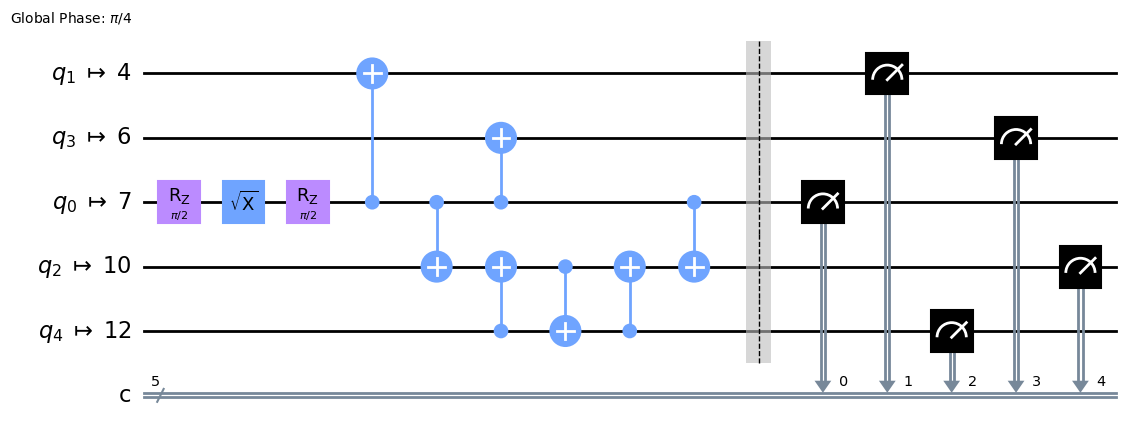

In [5]:
transpiled_circuit.draw("mpl", idle_wires=False)

# ZNE Circuit Transformation

In [6]:
class Local2qFolding(TransformationPass):
    """A circuit transformation pass to create noise-amplified version of a circuit\
    by folding 2-qubit gates in the circuit.
    
    The pass identifies the gate (op) nodes of the specified 2-qubit gate (`self.folding_gate`)
    and replace the node with a folded version of the gate (G) such as `G*G^-1*G`,
    `G*G^-1*G*G^-1*G`, and so on.
    
    In IBM systems, the available 2q gates are CX, ECR, and CZ, and each of them
    is inverse of its own (i.e., the inverese of ECR is ECR itself). Thus, repeating an IBM 2q gate an odd integer
    numer of times folds the gate (increases gate counts or noise but keeps the logical functionality intact).
    """
    def __init__(self, scale_factor, folding_gate):
        super().__init__()
        self.scale_factor = scale_factor
        self.folding_gate = folding_gate
        
    def run(self, dag):
        for run in dag.collect_runs([self.folding_gate]):
            for node in run: # iterates over all op nodes of self.folding_gate
                # create an empty DAG that will replace the op node
                fold_dag = DAGCircuit()

                # Add a register of qubits (here always 2Q)
                qreg = QuantumRegister(2)
                fold_dag.add_qreg(qreg)
                
                # adding the 2q gate an odd number of times in the DAG
                for _ in range(self.scale_factor):
                    fold_dag.apply_operation_back(node.op, [qreg[0], qreg[1]])
                
                # Replace the op node in the original DAG
                dag.substitute_node_with_dag(node, fold_dag)
                
        return dag   

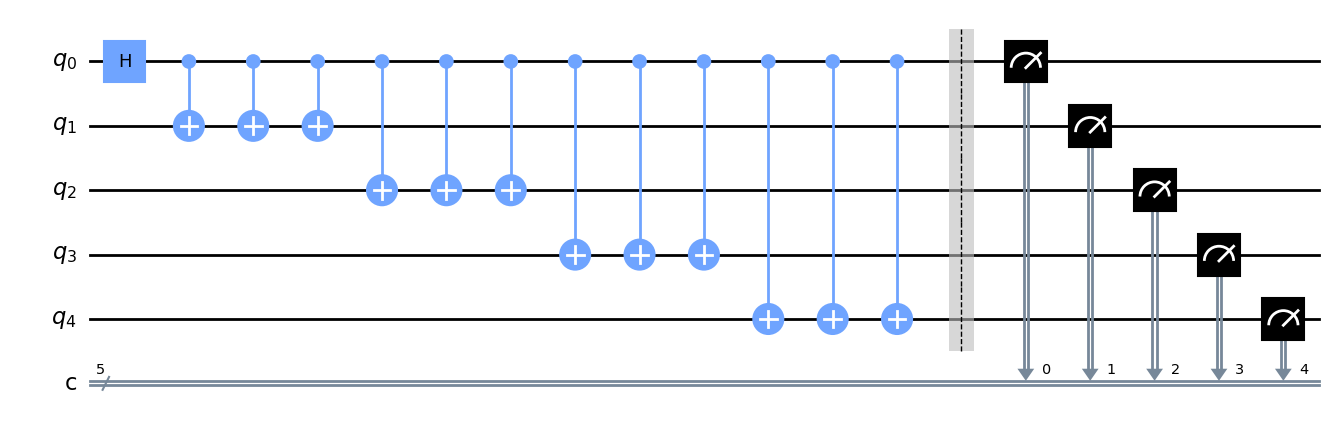

In [7]:
# Using the ZNE circuit transformation pass
# scale_factor=3 --> the 2q gate (CX) is supposed to be repeated 3 times
pm = PassManager([Local2qFolding(scale_factor=3, folding_gate='cx')])
circuit3x = pm.run(circuit)
circuit3x.draw("mpl")

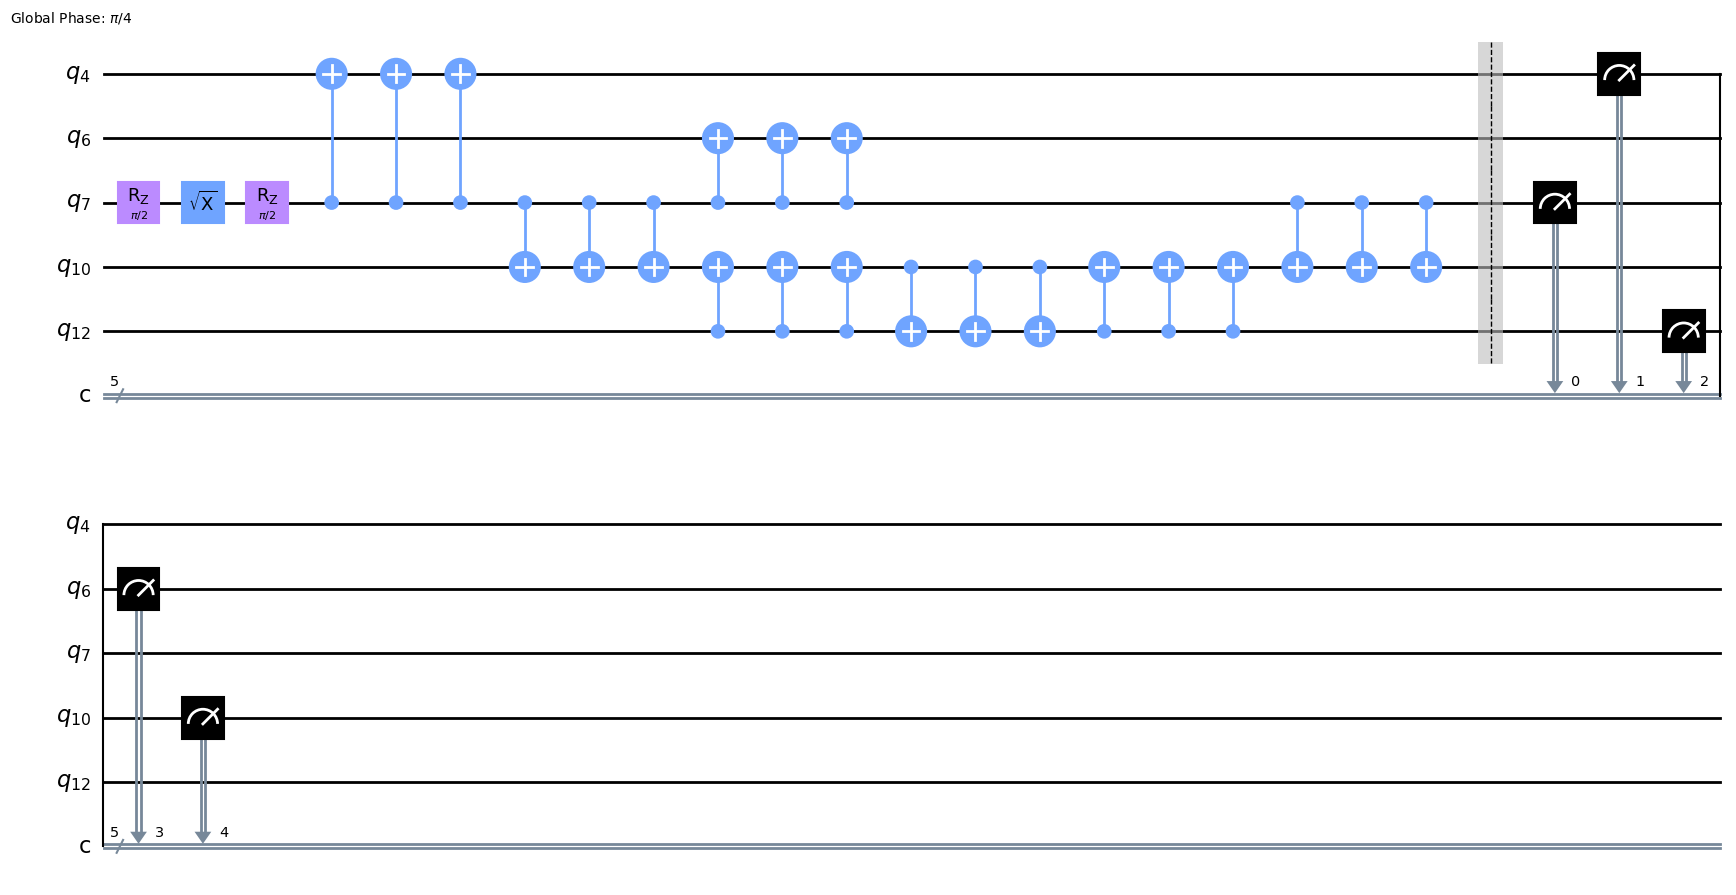

In [8]:
transpiled_circuit3x = pm.run(transpiled_circuit)
transpiled_circuit3x.draw("mpl", idle_wires=False)

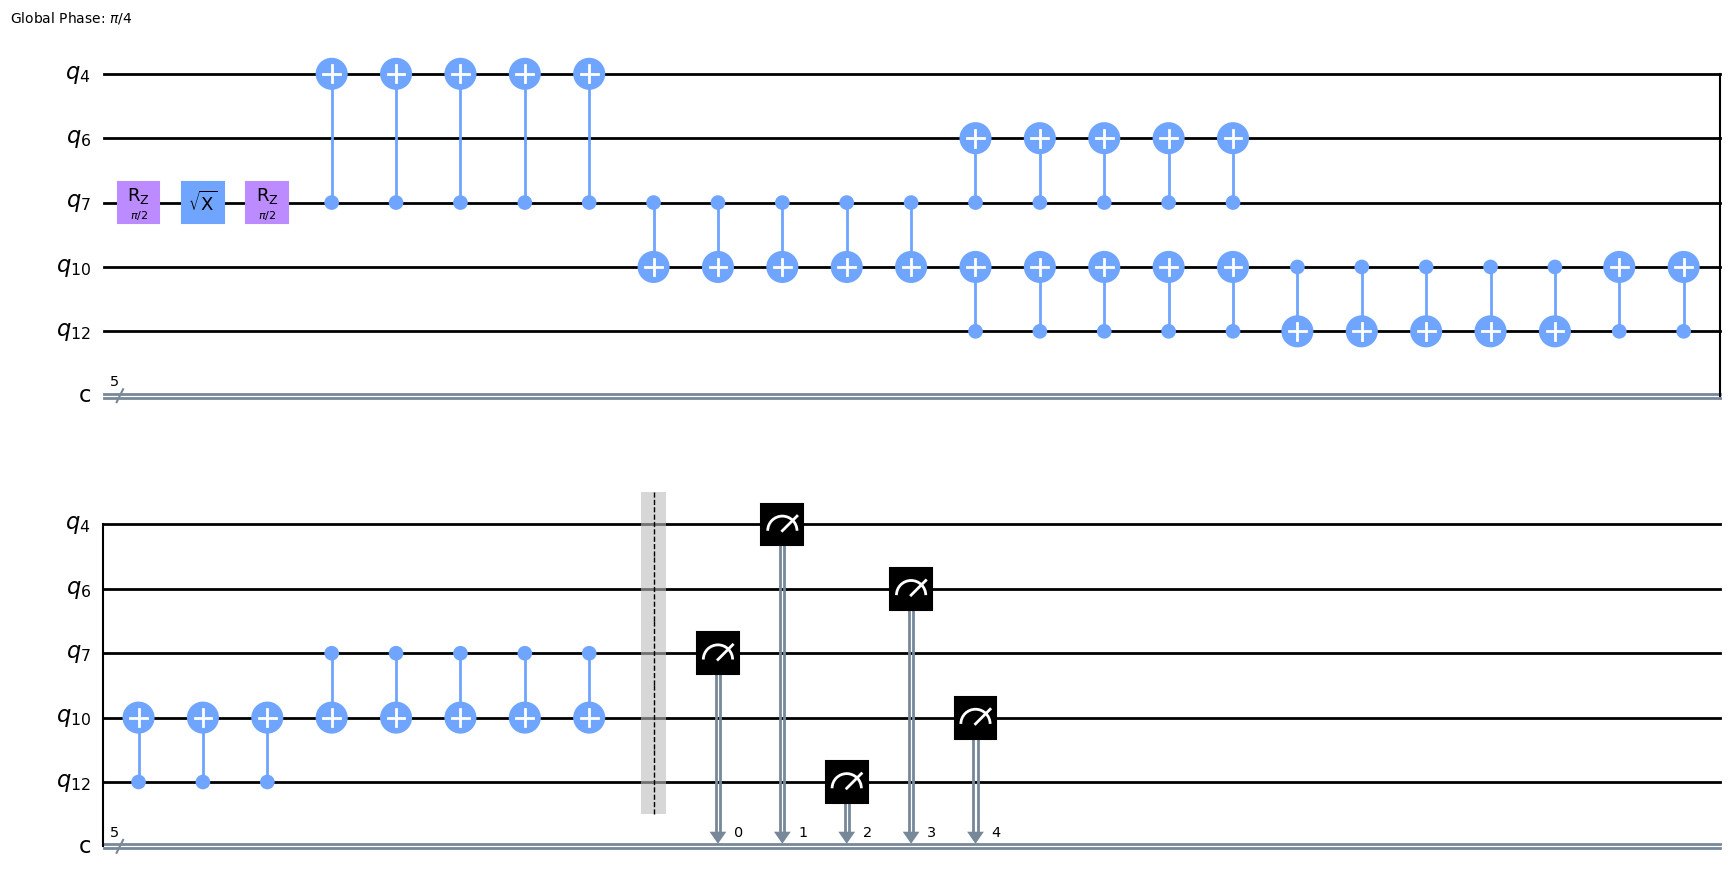

In [9]:
# scale_factor=5 --> the 2q gate (CX) is supposed to be repeated 5 times
pm = PassManager([Local2qFolding(scale_factor=5, folding_gate='cx')])
transpiled_circuit5x = pm.run(transpiled_circuit)
transpiled_circuit5x.draw("mpl", idle_wires=False)

# Circuit Execution

In [10]:
# ideal simulation
ideal_counts = ideal_simulator.run(transpiled_circuit, shots=10000).result().get_counts()

In [11]:
# Convert Counts to expectation value
ideal_expval = sampled_expectation_value(dist=ideal_counts, oper=operator)

In [12]:
zne_circ_list = [transpiled_circuit, transpiled_circuit3x, transpiled_circuit5x]
noisy_counts = backend.run(zne_circ_list, shots=10000).result().get_counts()

In [13]:
# Convert Counts to expectation value as ZNE works on expectation value only
noisy_expvals = [sampled_expectation_value(dist=dist, oper=operator) for dist in noisy_counts]

# Post-processing

In [14]:
# Now, we will fit the expectation values to extrapolate into zero noise limit
# using numpy.polyfit
# x values --> noise scale factors, i.e., [1, 3, 5]
# y values --> expectation values at each noise level
# linear fit
p = np.polyfit(x=[1, 3, 5], y=noisy_expvals, deg=1)

In [15]:
zero_noise_limit = np.polyval(p, x=0)

In [16]:
print(f"ideal expectation value: {ideal_expval}")
print(f"noisy expectation value: {noisy_expvals[0]}")
print(f"mitigated expecation value (zne): {zero_noise_limit} ")

ideal expectation value: -0.0016
noisy expectation value: 0.0758
mitigated expecation value (zne): 0.06926666666666668 


In [17]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit.tools.jupyter
%qiskit_version_table

numpy version 1.23.5
qiskit runtime version 0.13.0
